In [2]:
%load_ext autoreload
%autoreload 2

import cv2
import torch
from kornia_moons.feature import *
import pycolmap
import os
import h5py
import kornia as K
import kornia.feature as KF
from fastprogress import progress_bar
import matplotlib.pyplot as plt

def load_torch_image(fname, device=torch.device('cpu')):
    img = K.image_to_tensor(cv2.imread(fname), False).float() /255.
    img = K.color.bgr_to_rgb(img.to(device))
    return img

device = torch.device('mps')
device = torch.device('cpu')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Download example data

In [93]:

!wget http://cmp.felk.cvut.cz/~mishkdmy/wooden_lady_subset.zip

--2023-03-13 14:17:32--  http://cmp.felk.cvut.cz/~mishkdmy/wooden_lady_subset.zip
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34534975 (33M) [application/zip]
Saving to: ‘wooden_lady_subset.zip.1’

wooden_lady_subset. 100%[===================>]  32,93M  6,53MB/s    in 5,1s    

2023-03-13 14:17:37 (6,50 MB/s) - ‘wooden_lady_subset.zip.1’ saved [34534975/34534975]



In [4]:
%%capture
!unzip -o wooden_lady_subset.zip

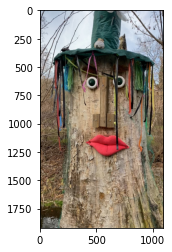

In [3]:
dirname = 'wooden_lady_subset'
img_fnames = [os.path.join(dirname, x) for x in os.listdir(dirname) if '.jpg' in x]
plt.imshow(cv2.cvtColor(cv2.imread(img_fnames[0]), cv2.COLOR_BGR2RGB))

In [15]:
def detect_features(img_fnames,
                    num_feats = 2048,
                    upright = True,
                    device=torch.device('cpu'),
                    feature_dir = '.featureout', resize_to = (800, 608)):
    disk = KF.DISK.from_pretrained('depth').to(device)
    if not os.path.isdir(feature_dir):
        os.makedirs(feature_dir)
    with h5py.File(f'{feature_dir}/lafs.h5', mode='w') as f_laf, \
         h5py.File(f'{feature_dir}/keypoints.h5', mode='w') as f_kp, \
         h5py.File(f'{feature_dir}/descriptors.h5', mode='w') as f_desc:
        for img_path in progress_bar(img_fnames):
            img_fname = img_path.split('/')[-1]
            key = img_fname
            with torch.inference_mode():
                timg = load_torch_image(img_path, device=device)
                H, W = timg.shape[2:]
                if H < W:
                    resize_to = resize_to[1], resize_to[0]
                timg_resized = K.geometry.resize(timg, resize_to, antialias=True)
                h, w = timg_resized.shape[2:]
                features = disk(timg_resized, num_feats, pad_if_not_divisible=True)[0]
                kps1, descs = features.keypoints, features.descriptors
                lafs = KF.laf_from_center_scale_ori(kps1[None],
                                             torch.ones(1, len(kps1), 1, 1,device=device))
                lafs[:,:,0,:] *= float(W) / float(w)
                lafs[:,:,1,:] *= float(H) / float(h)
                desc_dim = descs.shape[-1]
                kpts = KF.get_laf_center(lafs).reshape(-1, 2).detach().cpu().numpy()
                descs = descs.reshape(-1, desc_dim).detach().cpu().numpy()
                f_laf[key] = lafs.detach().cpu().numpy()
                f_kp[key] = kpts
                f_desc[key] = descs
    return


## Detect KeyNetAffNet features

In [21]:
detect_features(img_fnames, 2048, device=device, resize_to=(800, 608))

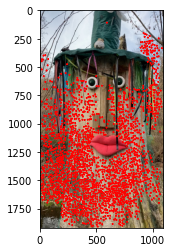

In [22]:
feature_dir = '.featureout'
with h5py.File(f'{feature_dir}/lafs.h5', mode='r') as f_laf:
    img1 = load_torch_image(img_fnames[0])
    key = img_fnames[0].split('/')[-1]
    lafs = torch.from_numpy(f_laf[key][...])
    visualize_LAF(img1, lafs)


## Matching

In [23]:
def get_unique_idxs(A):
    # https://stackoverflow.com/questions/72001505/how-to-get-unique-elements-and-their-firstly-appeared-indices-of-a-pytorch-tenso
    unique, idx, counts = torch.unique(A, dim=0, sorted=True, return_inverse=True, return_counts=True)
    _, ind_sorted = torch.sort(idx, stable=True)
    cum_sum = counts.cumsum(0)
    cum_sum = torch.cat((torch.tensor([0],device=cum_sum.device), cum_sum[:-1]))
    first_indicies = ind_sorted[cum_sum]
    return first_indicies

def match_features(img_fnames,
                   index_pairs,
                   feature_dir = '.featureout',
                   device=torch.device('cpu'),
                   min_matches=15, force_mutual = True):
    with h5py.File(f'{feature_dir}/lafs.h5', mode='r') as f_laf, \
         h5py.File(f'{feature_dir}/descriptors.h5', mode='r') as f_desc, \
        h5py.File(f'{feature_dir}/matches.h5', mode='w') as f_match:
        adalam_config = KF.adalam.get_adalam_default_config()
        #adalam_config['orientation_difference_threshold'] = None
        #adalam_config['scale_rate_threshold'] = None
        adalam_config['force_seed_mnn']= False
        adalam_config['search_expansion'] = 16
        adalam_config['ransac_iters'] = 256
        for pair_idx in progress_bar(index_pairs):
                    idx1, idx2 = pair_idx
                    fname1, fname2 = img_fnames[idx1], img_fnames[idx2]
                    key1, key2 = fname1.split('/')[-1], fname2.split('/')[-1]
                    lafs1 = torch.from_numpy(f_laf[key1][...]).to(device)
                    lafs2 = torch.from_numpy(f_laf[key2][...]).to(device)
                    desc1 = torch.from_numpy(f_desc[key1][...]).to(device)
                    desc2 = torch.from_numpy(f_desc[key2][...]).to(device)
                    img1, img2 = cv2.imread(fname1), cv2.imread(fname2)
                    hw1, hw2 = img1.shape[:2], img2.shape[:2]
                    dists, idxs = KF.match_adalam(desc1, desc2,
                                                  lafs1, lafs2, # Adalam takes into account also geometric information
                                                  hw1=hw1, hw2=hw2,
                                                  config=adalam_config) # Adalam also benefits from knowing image size
                    if len(idxs)  == 0:
                        continue
                    # Force mutual nearest neighbors
                    if force_mutual:
                        first_indicies = get_unique_idxs(idxs[:,1])
                        idxs = idxs[first_indicies]
                        dists = dists[first_indicies]
                    n_matches = len(idxs)
                    if False:
                        print (f'{key1}-{key2}: {n_matches} matches')
                    group  = f_match.require_group(key1)
                    if n_matches >= min_matches:
                         group.create_dataset(key2, data=idxs.detach().cpu().numpy().reshape(-1, 2))
    return


In [24]:
# matching all to all
index_pairs = []
for i in range(len(img_fnames)):
    for j in range(i+1, len(img_fnames)):
        index_pairs.append((i,j))


In [25]:
match_features(img_fnames, index_pairs, device=torch.device('cpu'))

## Import into colmap and run reconstruction

In [26]:
from h5_to_db import add_keypoints, add_matches, COLMAPDatabase

def import_into_colmap(img_dir,
                       feature_dir ='.featureout',
                       database_path = 'colmap.db',
                       img_ext='.jpg'):
    db = COLMAPDatabase.connect(database_path)
    db.create_tables()
    single_camera = False
    fname_to_id = add_keypoints(db, feature_dir, img_dir, img_ext, 'simple-radial', single_camera)
    add_matches(
        db,
        feature_dir,
        fname_to_id,
    )

    db.commit()
    return

database_path = 'colmap.db'
!rm {database_path}
import_into_colmap(dirname, database_path=database_path)

100%|███████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 1197.75it/s]
246it [00:00, 4765.53it/s]                                                                                


In [33]:
output_path = 'colmap_rec_disk'


In [34]:

def run_reconstruction(image_dir, output_path = 'colmap_rec', database_path = 'colmap.db'):
    pycolmap.match_exhaustive(database_path)
    maps = pycolmap.incremental_mapping(database_path, dirname, output_path)
    if not os.path.isdir(output_path):
        os.makedirs(output_path)
    maps[0].write(output_path)
    return maps

In [35]:
maps = run_reconstruction(dirname, output_path, database_path)


Exhaustive feature matching

Matching block [1/1, 1/1] in 0.001s
Elapsed time: 0.000 [minutes]

Loading database

Loading cameras... 23 in 0.000s
Loading matches... 246 in 0.001s
Loading images... 23 in 0.001s (connected 23)
Building correspondence graph... in 0.006s (ignored 0)

Elapsed time: 0.000 [minutes]


Finding good initial image pair


Initializing with image pair #12 and #10


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  4.300115e+02    0.00e+00    1.17e+03   0.00e+00   0.00e+00  1.00e+04        0    4.65e-04    1.40e-03
   1  4.197139e+02    1.03e+01    1.26e+04   1.48e+01   9.86e-01  3.00e+04        1    9.99e-04    2.41e-03
   2  4.142564e+02    5.46e+00    1.68e+04   2.28e+01   9.57e-01  9.00e+04        1    9.26e-04    3.34e-03
   3  4.124486e+02    1.81e+00    7.13e+03   2.15e+01   8.87e-01  1.68e+05        1    9.12e-04    4.25e-03
   4  4.119069e+02    5.42e-01    1.86e+03 


Bundle adjustment report
------------------------
    Residuals : 7204
   Parameters : 4091
   Iterations : 18
         Time : 0.0427821 [s]
 Initial cost : 0.466887 [px]
   Final cost : 0.441318 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 0
  => Filtered observations: 51
  => Changed observations: 0.014159

Bundle adjustment report
------------------------
    Residuals : 7102
   Parameters : 4088
   Iterations : 4
         Time : 0.0110772 [s]
 Initial cost : 0.440025 [px]
   Final cost : 0.42646 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 3
  => Filtered observations: 0
  => Changed observations: 0.000845

Retriangulation

  => Completed observations: 0
  => Merged observations: 0
  => Retriangulated observations: 0

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.293366e+03    0.00e+00    1.03e+0


Bundle adjustment report
------------------------
    Residuals : 14334
   Parameters : 5768
   Iterations : 21
         Time : 0.130898 [s]
 Initial cost : 0.539526 [px]
   Final cost : 0.486266 [px]
  Termination : Convergence

  => Merged observations: 14
  => Completed observations: 3
  => Filtered observations: 90
  => Changed observations: 0.014930

Bundle adjustment report
------------------------
    Residuals : 14160
   Parameters : 5750
   Iterations : 7
         Time : 0.0432451 [s]
 Initial cost : 0.527953 [px]
   Final cost : 0.512537 [px]
  Termination : Convergence

  => Merged observations: 4
  => Completed observations: 17
  => Filtered observations: 0
  => Changed observations: 0.002966

Retriangulation

  => Completed observations: 4
  => Merged observations: 0
  => Retriangulated observations: 0

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  3.757941e+03    0.00e+00    5.7


Bundle adjustment report
------------------------
    Residuals : 17528
   Parameters : 3782
   Iterations : 12
         Time : 0.07286 [s]
 Initial cost : 0.51182 [px]
   Final cost : 0.501631 [px]
  Termination : Convergence

  => Merged observations: 57
  => Completed observations: 16
  => Filtered observations: 77
  => Changed observations: 0.017115

Bundle adjustment report
------------------------
    Residuals : 17408
   Parameters : 3752
   Iterations : 3
         Time : 0.018497 [s]
 Initial cost : 0.581313 [px]
   Final cost : 0.571434 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 15
  => Filtered observations: 2
  => Changed observations: 0.001953

Retriangulation

  => Completed observations: 25
  => Merged observations: 0
  => Retriangulated observations: 0

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  6.820645e+03    0.00e+00    4.92

   6  9.142871e+03    6.50e-03    8.42e+00   1.80e+00   1.02e+00  5.10e+06        1    1.43e-02    9.77e-02
   7  9.142871e+03    1.16e-04    1.98e+00   2.41e-01   1.09e+00  1.53e+07        1    1.45e-02    1.12e-01
   8  9.142871e+03    3.59e-06    2.38e-01   2.07e-02   1.28e+00  4.59e+07        1    1.39e-02    1.26e-01


Bundle adjustment report
------------------------
    Residuals : 27060
   Parameters : 9168
   Iterations : 9
         Time : 0.126191 [s]
 Initial cost : 0.582223 [px]
   Final cost : 0.581269 [px]
  Termination : Convergence

  => Completed observations: 1
  => Merged observations: 0
  => Filtered observations: 0
  => Changed observations: 0.000074
  => Filtered images: 0

Registering image #16 (12)

  => Image sees 1082 / 1282 points

Pose refinement report
----------------------
    Residuals : 2350
   Parameters : 8
   Iterations : 12
         Time : 0.00591898 [s]
 Initial cost : 0.65534 [px]
   Final cost : 0.597764 [px]
  Termination : Convergence

  => Con

   1  1.340493e+04    1.39e+01    6.47e+00   5.01e-01   1.00e+00  3.00e+04        1    2.30e-02    4.01e-02
   2  1.340492e+04    8.20e-03    1.90e+00   5.91e-01   9.90e-01  9.00e+04        1    2.30e-02    6.31e-02
   3  1.340492e+04    1.06e-03    1.06e+00   3.29e-01   1.00e+00  2.70e+05        1    2.19e-02    8.50e-02
   4  1.340492e+04    8.55e-05    4.85e-01   8.23e-02   1.03e+00  8.10e+05        1    2.18e-02    1.07e-01


Bundle adjustment report
------------------------
    Residuals : 36260
   Parameters : 9941
   Iterations : 5
         Time : 0.107035 [s]
 Initial cost : 0.608337 [px]
   Final cost : 0.608021 [px]
  Termination : Convergence

  => Completed observations: 0
  => Merged observations: 0
  => Filtered observations: 0
  => Changed observations: 0.000000
  => Filtered images: 0

Registering image #8 (16)

  => Image sees 776 / 1579 points

Pose refinement report
----------------------
    Residuals : 1524
   Parameters : 8
   Iterations : 11
         Time : 0.003

  => Merged observations: 5
  => Completed observations: 29
  => Filtered observations: 4
  => Changed observations: 0.003965

Retriangulation

  => Completed observations: 12
  => Merged observations: 0
  => Retriangulated observations: 7

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  3.278313e+04    0.00e+00    4.50e+04   0.00e+00   0.00e+00  1.00e+04        0    7.46e-03    2.38e-02
   1  2.604642e+04    6.74e+03    1.33e+03   2.81e+01   1.00e+00  3.00e+04        1    2.98e-02    5.36e-02
   2  2.601660e+04    2.98e+01    1.09e+03   2.04e+01   1.02e+00  9.00e+04        1    2.83e-02    8.19e-02
   3  2.601381e+04    2.79e+00    4.51e+02   1.73e+01   9.55e-01  2.70e+05        1    2.79e-02    1.10e-01
   4  2.601264e+04    1.17e+00    7.42e+02   1.90e+01   6.80e-01  2.83e+05        1    2.83e-02    1.38e-01
   5  2.601176e+04    8.81e-01    1.90e+02   9.35e+00   9.63e-01  8.50e+05        1  


Bundle adjustment report
------------------------
    Residuals : 18920
   Parameters : 2609
   Iterations : 17
         Time : 0.0821278 [s]
 Initial cost : 0.577855 [px]
   Final cost : 0.55503 [px]
  Termination : Convergence

  => Merged observations: 50
  => Completed observations: 51
  => Filtered observations: 92
  => Changed observations: 0.020402

Bundle adjustment report
------------------------
    Residuals : 18906
   Parameters : 2582
   Iterations : 3
         Time : 0.01542 [s]
 Initial cost : 0.663086 [px]
   Final cost : 0.65232 [px]
  Termination : Convergence

  => Merged observations: 10
  => Completed observations: 17
  => Filtered observations: 1
  => Changed observations: 0.002962

Retriangulation

  => Completed observations: 34
  => Merged observations: 0
  => Retriangulated observations: 2

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  3.004318e+04    0.00e+00    5.5

In [36]:
print (maps[0].summary())

Reconstruction:
	num_reg_images = 23
	num_cameras = 23
	num_points3D = 4655
	num_observations = 27950
	mean_track_length = 6.0043
	mean_observations_per_image = 1215.22
	mean_reprojection_error = 1.01259


## Visualize with colmap GUI 

As you 

## Visualize with colmap GUI 

As you can see, DISK reconstructs tree, but completely ignores human-like part. The camera poses are goo though.

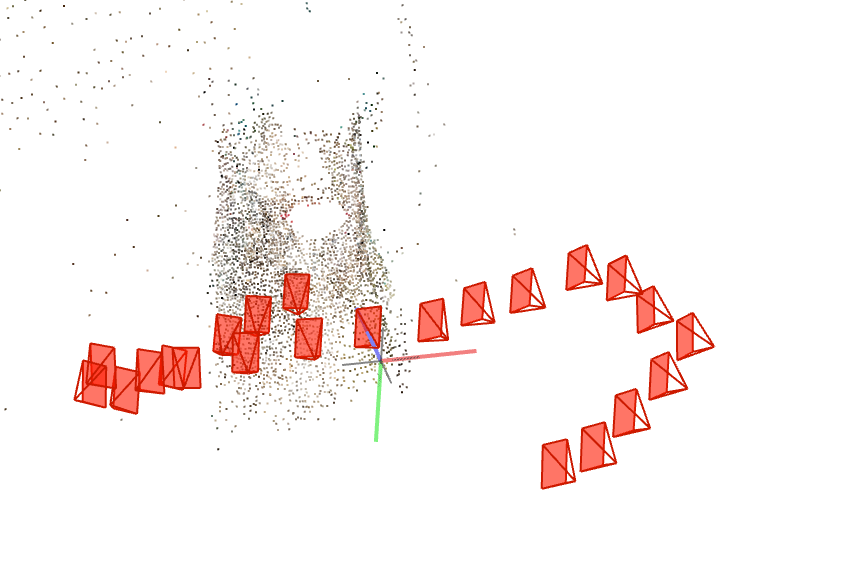